# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [12]:
%pylab
%matplotlib inline
plt.style.use('ggplot')

img = X_train[100]

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


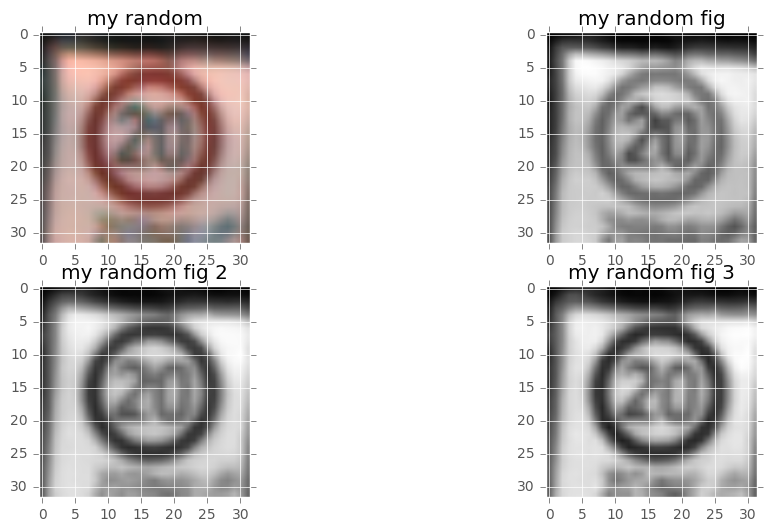

In [78]:
img = X_train[100]

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
plt.subplot(221)
plt.title('my random')
plt.imshow(img)
plt.subplot(222)
plt.title('my random fig')
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(223)
plt.title('my random fig 2')
plt.imshow(img[:,:,1], cmap='gray')
plt.subplot(224)
plt.title('my random fig 3')
plt.imshow(img[:,:,2], cmap='gray')

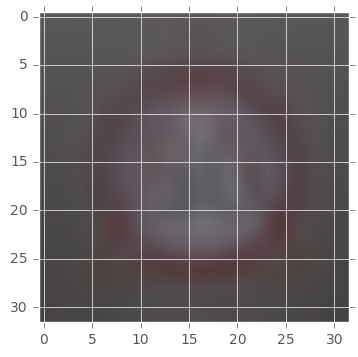

In [19]:
mean_img = np.mean(X_train, axis=0)

plt.imshow(mean_img.astype(np.uint8))

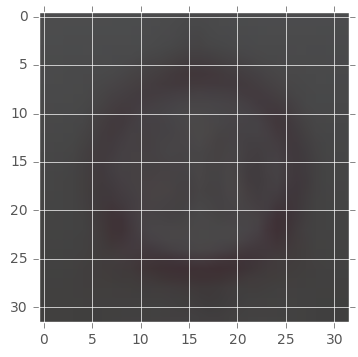

In [20]:
std_img = np.std(X_train, axis=0)

plt.imshow(std_img.astype(np.uint8))

Where changes are likely to be on an image. Where and how much variance is in the mean representation of the traffic sign.

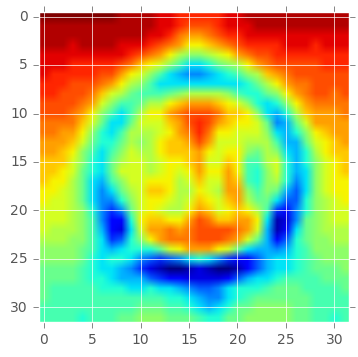

In [23]:
plt.imshow(np.mean(std_img, axis=2).astype(np.uint8))

On average how much each color channel will change as a heat map, the more red the more likely our mean image is different from the each image, and the more blue, the more blue, the more likely our mean image represents any given image.

The point of these explorations is that machine learning is about building models that understand invariances. We need our model to be able to generalize unseen data. By modeling the mean and the standard deviation of the dataset, we are able to understand what our model should be able to generalize properly.

One thing we could do to help create a better model is to preprocess the data. For example, we could remove the mean and the standard deviation from the images to only keep a dataset that contains the variations of the data. This would be a simple operation such as substracting the mean and dividing by the standard deviation. Also known as normalization. Let's take a look at what this means:

In [33]:
flattened = X_train.ravel()
flattened[:50]

array([ 75,  78,  80,  74,  76,  78,  83,  84,  83, 101,  92,  85, 130,
       107, 102, 153, 113, 114, 173, 114, 117, 188, 124, 124, 190, 151,
       150, 243, 228, 230, 255, 250, 255, 243, 239, 255, 232, 235, 255,
       170, 180, 212, 127, 146, 182, 124, 153, 175, 156, 181], dtype=uint8)

We can further explore the images by visualizing the distribution or range of frequency of possible values are. This would tell us whether the data is predictable or not by pointing things that would happen more than anything else. If there is, a Neural Network would be able to take advantage of it.

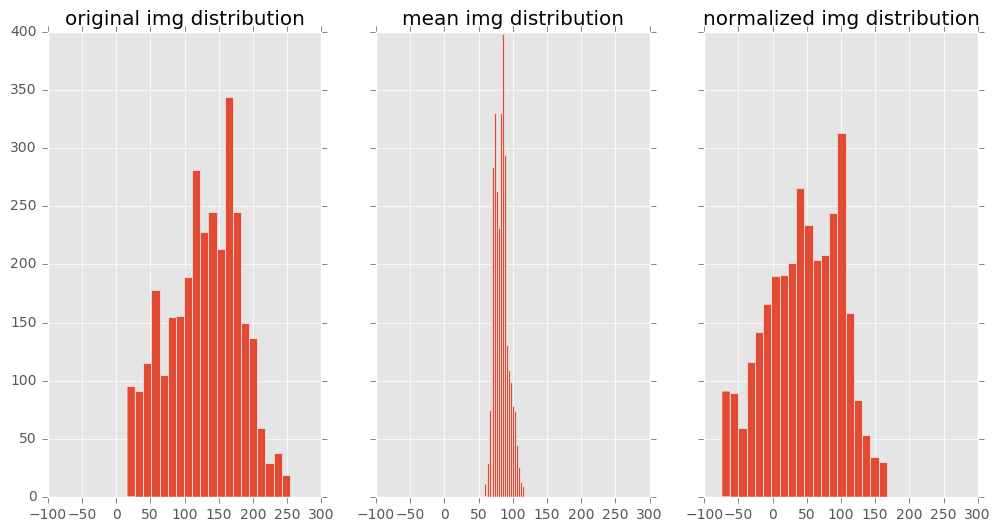

In [38]:
bins = 20
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist(img.ravel(), bins)
axs[0].set_title('original img distribution')
axs[1].hist(mean_img.ravel(), bins)
axs[1].set_title('mean img distribution')
axs[2].hist((img-mean_img).ravel(), bins)
axs[2].set_title('(org-mean) img distribution')

From the graph we can see the number of pixels intensity distribution, the mean image distribution around 80 and then the normalized image showing the number of pixels that were above and below the mean for this particular image.

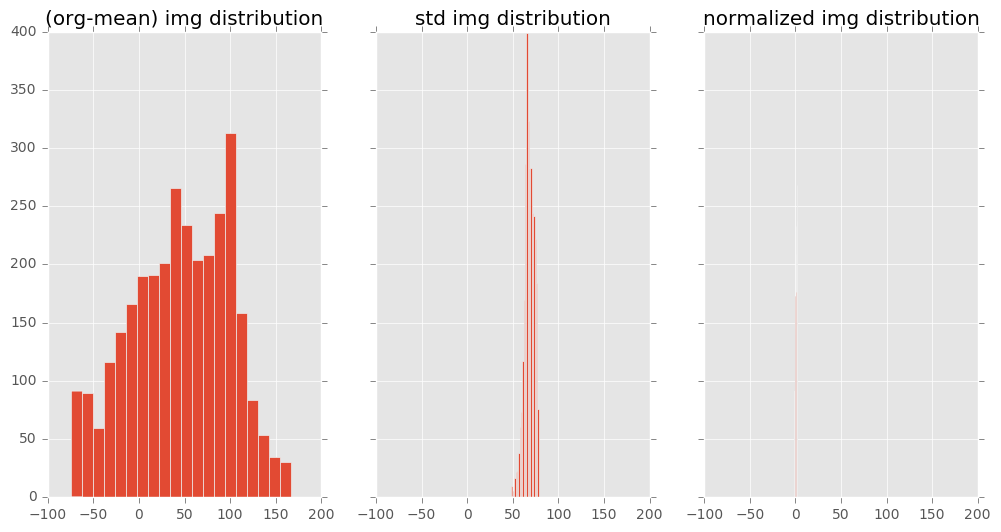

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((img-mean_img).ravel(), bins)
axs[0].set_title('(org-mean) img distribution')
axs[1].hist(std_img.ravel(), bins)
axs[1].set_title('std img distribution')
axs[2].hist(((img-mean_img)/std_img).ravel(), bins)
axs[2].set_title('normalized img distribution')

We can hardly see the normalized values, but let's zoom in to be able to better identify the distribution.

(array([  91.,   93.,   74.,  135.,  140.,  144.,  173.,  172.,  178.,
         233.,  209.,  190.,  191.,  176.,  237.,  268.,  148.,  108.,
          54.,   58.]),
 array([-0.97876036, -0.817667  , -0.65657365, -0.49548029, -0.33438693,
        -0.17329357, -0.01220021,  0.14889315,  0.3099865 ,  0.47107986,
         0.63217322,  0.79326658,  0.95435994,  1.1154533 ,  1.27654665,
         1.43764001,  1.59873337,  1.75982673,  1.92092009,  2.08201345,
         2.2431068 ]),
 <a list of 20 Patch objects>)

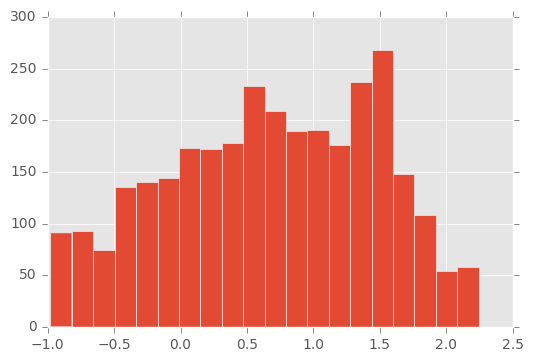

In [52]:
plt.hist(((img-mean_img)/std_img).ravel(), bins)

By normalizing the dataset, all the values would tend to be around 0 and on a smaller range, in this case from -1 to 2.


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [8]:
import tensorflow as tf

def weight_variable(shape, stddev = 0.01):
    """
    Initialize weight with slight amount of noise to
    break symmetry and prevent zero gradients
    """
    initial = tf.truncated_normal(shape, stddev = stddev)
    return tf.Variable(initial)

def bias_variable(shape, value = 0.1):
    """
    Initialize ReLU neurons with slight positive initial
    bias to avoid dead neurons
    """
    initial = tf.constant(value, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride = 1):
    """
    We use a stride size of 1 and zero padded convolutions
    to ensure we get the same output size as it was our input
    """
    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")

def max_pool_nxn(x, n = 2):
    """
    Our pooling is plain old max pooling over 2x2 blocks
    """
    return tf.nn.max_pool(x, ksize = [1, n, n, 1],
                          strides = [1, n, n, 1], padding = "SAME")

def build_weights_biases(weights_shape):
    """
    Build the weights and bias of a convolutional layer
    """
    return weight_variable(weights_shape), bias_variable(weights_shape[-1:])

def convolve_relu_pool(nn_input, weights_shape, stride = 4, pool = True):
    """
    Convolve the input to the network with the weight tensor,
    add the bias, apply the ReLU function and finally max pool
    """
    W_conv, b_conv = build_weights_biases(weights_shape)
    h_conv = tf.nn.relu(conv2d(nn_input, W_conv, stride) + b_conv)
    if not pool:
        return h_conv
    return max_pool_nxn(h_conv)

In [12]:
img_width = image_shape[0]
img_height = image_shape[1]
img_channels = image_shape[2]

#input_batch = tf.placeholder("float", [None, img_width, img_height, img_channels])

x = tf.placeholder(tf.float32, shape=[None, img_width * img_height])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

#x = tf.placeholder(tf.float32, shape=[None, 784])
#y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5, 5, 3, 64])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,img_height,img_width,img_channels])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_nxn(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_nxn(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


"""
# create the first convolutional layers
h_pool1 = convolve_relu_pool(input_batch, [8, 8, img_channels, 32])
h_conv2 = convolve_relu_pool(h_pool1, [4, 4, 32, 64], 2, False)
h_conv3 = convolve_relu_pool(h_conv2, [3, 3, 64, 64], 1, False)

# create the densely connected layers
W_fc1, b_fc1 = build_weights_biases([5 * 5 * 64, 512])
h_conv3_flat = tf.reshape(h_conv3, [-1, 5 * 5 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

# finally add the readout layer
W_fc2, b_fc2 = build_weights_biases([512, self.noutputs])
readout = tf.matmul(h_fc1, W_fc2) + b_fc2

readout_action = tf.reduce_sum(tf.mul(readout, self.a), reduction_indices=1)
cost_function = tf.reduce_mean(tf.square(self.y - readout_action))
train_step = tf.train.AdamOptimizer(1e-8).minimize(cost_function)

return input_image, readout, h_fc1, train_step
"""


'\n# create the first convolutional layers\nh_pool1 = convolve_relu_pool(input_batch, [8, 8, img_channels, 32])\nh_conv2 = convolve_relu_pool(h_pool1, [4, 4, 32, 64], 2, False)\nh_conv3 = convolve_relu_pool(h_conv2, [3, 3, 64, 64], 1, False)\n\n# create the densely connected layers\nW_fc1, b_fc1 = build_weights_biases([5 * 5 * 64, 512])\nh_conv3_flat = tf.reshape(h_conv3, [-1, 5 * 5 * 64])\nh_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)\n\n# finally add the readout layer\nW_fc2, b_fc2 = build_weights_biases([512, self.noutputs])\nreadout = tf.matmul(h_fc1, W_fc2) + b_fc2\n\nreadout_action = tf.reduce_sum(tf.mul(readout, self.a), reduction_indices=1)\ncost_function = tf.reduce_mean(tf.square(self.y - readout_action))\ntrain_step = tf.train.AdamOptimizer(1e-8).minimize(cost_function)\n\nreturn input_image, readout, h_fc1, train_step\n'

In [16]:
sess = tf.InteractiveSession()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.12
step 100, training accuracy 0.56
step 200, training accuracy 0.92
step 300, training accuracy 0.86
step 400, training accuracy 0.9
step 500, training accuracy 0.86
step 600, training accuracy 0.98
step 700, training accuracy 0.9
step 800, training accuracy 0.8
step 900, training accuracy 0.98
step 1000, training accuracy 0.92
step 1100, training accuracy 0.98
step 1200, training accuracy 0.96
step 1300, training accuracy 0.94
step 1400, training accuracy 0.92
step 1500, training accuracy 0.92
step 1600, training accuracy 0.94
step 1700, training accuracy 0.96
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 0.96
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 0.98
step 3000, tr

In [3]:
import tensorflow as tf

def _activation_summary(x):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measures the sparsity of activations.
    Args:
        x: Tensor
    Returns:
        nothing
    """
    tf.histogram_summary(x.op.name + '/activations', x)
    tf.scalar_summary(x.op.name + '/sparsity', tf.nn.zero_fraction(x))

def _variable_on_cpu(name, shape, initializer):
    """Helper to create a Variable stored on CPU memory.
    Args:
        name: name of the variable
        shape: list of ints
        initializer: initializer for Variable
    Returns:
        Variable Tensor
    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var


def _variable_with_weight_decay(name, shape, stddev, wd):
    """Helper to create an initialized Variable with weight decay.
    Note that the Variable is initialized with a truncated normal distribution.
    A weight decay is added only if one is specified.
    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.
    Returns:
        Variable Tensor
    """
    var = _variable_on_cpu(
            name,
            shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [5]:
img_width = image_shape[0]
img_height = image_shape[1]
img_channels = image_shape[2]

images = tf.placeholder("float", [None, img_width, img_height, img_channels])

# conv1
kernel = _variable_with_weight_decay('weights',
                                     shape=[5, 5, 3, 64],
                                     stddev=5e-2,
                                     wd=0.0)
conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
bias = tf.nn.bias_add(conv, biases)
conv1 = tf.nn.relu(bias, name='conv1')
_activation_summary(conv1)

# pool1
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')
  
# norm1
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

# conv2
kernel = _variable_with_weight_decay('weights',
                                     shape=[5, 5, 64, 64],
                                     stddev=5e-2,
                                     wd=0.0)
conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
bias = tf.nn.bias_add(conv, biases)
conv2 = tf.nn.relu(bias, name='conv2')
_activation_summary(conv2)

# norm2
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                  name='norm2')

# pool2
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                       strides=[1, 2, 2, 1], padding='SAME', name='pool2')

# local3
reshape = tf.reshape(pool2, [32, -1])
dim = reshape.get_shape()[1].value
weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                      stddev=0.04, wd=0.004)
biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name='local3')
_activation_summary(local3)

# local4
weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                      stddev=0.04, wd=0.004)
biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
_activation_summary(local4)

# softmax_linear
weights = _variable_with_weight_decay('weights', [192, n_classes],
                                      stddev=1/192.0, wd=0.0)
biases = _variable_on_cpu('biases', [n_classes],tf.constant_initializer(0.0))
softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
_activation_summary(softmax_linear)

# softmax_linear

ValueError: Variable weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-3-4545b79eb6de>", line 25, in _variable_on_cpu
    var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
  File "<ipython-input-3-4545b79eb6de>", line 45, in _variable_with_weight_decay
    tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
  File "<ipython-input-4-a7a9895e6eed>", line 11, in <module>
    wd=0.0)


# Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.